## Assignment 2: $k$ Nearest Neighbor

### Do any four.

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error

**Q1.** Please answer the following questions.

1. What is the difference between regression and classification?

Regression predicts a continuous number, like a price or a rating.  Classification predicts a category, like which type of mine or whether someone died.  The output is different, so the error metrics are different too.

2. What is a confusion table/matrix? What does it help us understand about a model's performance?

A confusion table shows you how many times the model predicted each class vs what the actual class was.  It helps you see not just overall accuracy but where the model is getting confused. It could be great at class 1 but always mixes up class 3 and 4.

3. What is Accuracy? Why might it not be entirely sufficient to evaluate a classifer's predictive performance?

Accuracy is just the proportion of predictions that were right.  The problem is it can be misleading when classes are imbalanced.  If 95% of your data is class 0, a model that always predicts 0 gets 95% accuracy without actually learning anything useful.

4. What does the root mean squared error quantify about a particular model?

RMSE measures how far off your predictions are from the actual values on average, in the same units as the target variable.  Bigger errors get penalized more because of the squaring, so it's sensitive to large mistakes.

5. What are overfitting and underfitting?

Overfitting is when the model fits the training data too closely and picks up on noise, so it does poorly on new data.  Underfitting is when the model is too simple and misses real patterns even in the training data.  With kNN, small k overfits and large k underfits.

6. Why does splitting the data into training and testing sets, and choosing $k$ by evaluating accuracy or RMSE on the test set, improve model performance?

If you pick k based on training error alone you'll always just pick k=1 since it memorizes the training set perfectly.  Using a test set that the model hasn't seen gives you a more realistic estimate of how it will perform on new data, so you pick the k that actually generalizes.

7. With classification, we can report a class label as a prediction or a probability distribution over class labels. Please explain the strengths and weaknesses of each approach.

A class label is simple, but you lose information about how confident the model is.  A probability distribution tells you more but it's harder to communicate and you have to decide where to draw the threshold yourself.

**Q2.** This is a case study on $k$ nearest neighbor classification, using the `land_mines.csv` data.

The data consists of a label, `mine_type`, taking integer values 1 to 5, and three properties of the mine, `voltage`, `height` and `soil`. We want to predict the kind of mine from data about it. Imagine working for the DOD or a humanitarian aid agency, trying to help people remove land mines more safely.

1. Load the data. Perform some EDA, summarizing the target label and the relationships between the features (e.g. scatterplots, describe tables).

In [56]:
mines = pd.read_csv("data/land_mines.csv")

In [57]:
mines.head()

,voltage,height,soil,mine_type
0,0.338157,0.000000,0.0,1
1,0.320241,0.181818,0.0,1
2,0.287009,0.272727,0.0,1
3,0.256284,0.454545,0.0,1
4,0.262840,0.545455,0.0,1


In [58]:
print(mines.shape)
print(mines['mine_type'].value_counts())
mines.describe()

(338, 4)
mine_type
1    71
2    70
3    66
4    66
5    65
Name: count, dtype: int64


,voltage,height,soil,mine_type
count,338.000000,338.000000,338.000000,338.000000
mean,0.430634,0.508876,0.503550,2.952663
std,0.195819,0.306043,0.344244,1.419703
min,0.197734,0.000000,0.000000,1.000000
25%,0.309737,0.272727,0.200000,2.000000
50%,0.359516,0.545455,0.600000,3.000000
75%,0.482628,0.727273,0.800000,4.000000
max,0.999999,1.000000,1.000000,5.000000


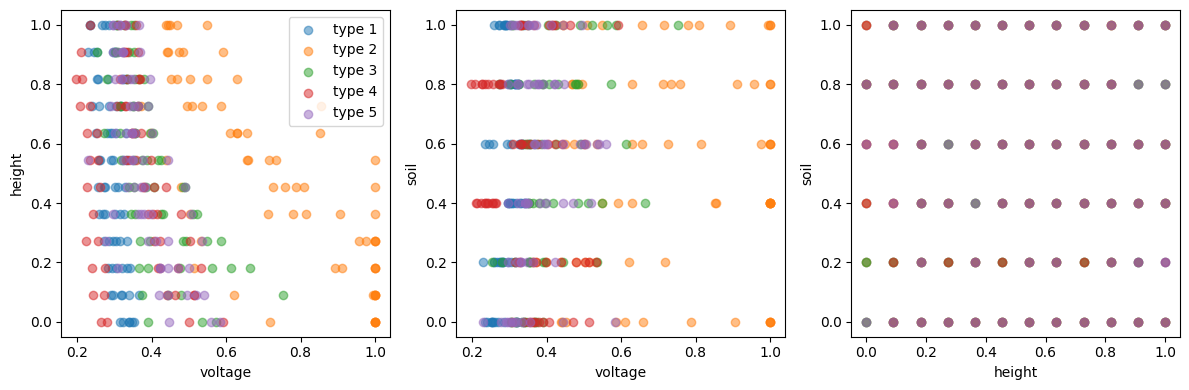

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
pairs = [('voltage', 'height'), ('voltage', 'soil'), ('height', 'soil')]
for ax, (xcol, ycol) in zip(axes, pairs):
    for mt in sorted(mines['mine_type'].unique()):
        subset = mines[mines['mine_type'] == mt]
        ax.scatter(subset[xcol], subset[ycol], alpha=0.5, label=f'type {mt}')
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
axes[0].legend()
plt.tight_layout()
plt.show()

Voltage and height separate the mine types pretty well, especially for type 2.  Soil vs height looks kind of useless since they blend so much.

2. Split the sample 50/50 into training and test/validation sets. (The smaller the data are, the more equal the split should be, in my experience: Otherwise, all of the members of one class end up in the training or test data, and the model falls apart.)

In [60]:
X = mines[['voltage', 'height', 'soil']]
y = mines['mine_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

3. Build a $k$-NN classifier. Explain how you select $k$.

best k: 2, accuracy: 0.40236686390532544


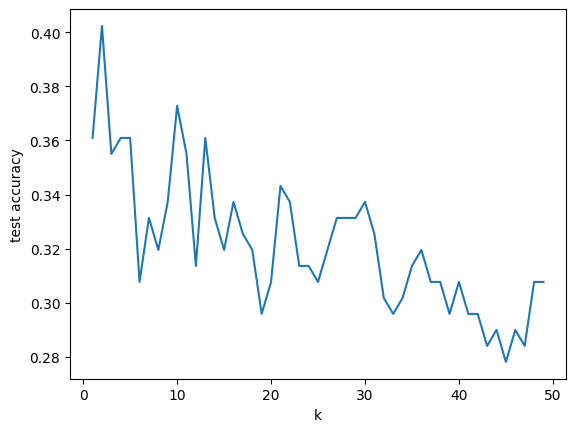

In [61]:
k_vals = range(1, 50)
accs = []
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accs.append(accuracy_score(y_test, knn.predict(X_test)))

best_k = k_vals[np.argmax(accs)]
print(f"best k: {best_k}, accuracy: {max(accs)}")

plt.plot(list(k_vals), accs)
plt.xlabel('k')
plt.ylabel('test accuracy')
plt.show()

I selected k by looping over k 1 to 50 and keeping the value that maximizes accuracy on the test set.

4. Print a confusion table for your best model, comparing predicted and actual class label on the test set. How accurate is it? Where is performance more or less accurate?

In [62]:
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

cm = pd.crosstab(y_test, pd.Series(y_pred, index=y_test.index), rownames=['actual'], colnames=['predicted'])
cm

predicted,1,2,3,4,5
actual,,,,,
1,17,0,18,2,0
2,0,25,4,4,0
3,8,3,16,2,3
4,12,5,10,7,2
5,8,2,12,6,3


Our accuracy we got with k=2 from the last cells was 40.2%.  Our model is just phenomenal at predicting type 2 mines, which we could have guessed from the great separation we saw in the scatter plots at the start for type 2.  It's really bad at predicting type 4 and 5, and middle of the road with the rest.

5. Notice that you can have a lot of accurate predictions for a given type of mine, but still make a lot of mistakes. Please explain how you'd advise someone to actually use this predictive model in practice, given the errors that it tends to make.

Well, I would say be very careful when dealing with mines in general, as the consequences are very high.  If it predicts a type 2 mine I would say it is quite likely it is actually a type 2 mine, but other than that it is basically a solid educated guess, and I really would not trust it to help me make big decisions.  If someone told me they were going to entrust their life with this model, I would keep it away from them out of moral duty.

**Q3.** This question is a case study for $k$ nearest neighbor regression, using the `USA_cars_datasets.csv` data.

The target variable `y` is `price` and the features are `year` and `mileage`.

1. Load the `./data/USA_cars_datasets.csv`. Keep the following variables and drop the rest: `price`, `year`, 
`mileage`. Are there any `NA`'s to handle? Look at the head and dimensions of the data.

In [63]:
cars = pd.read_csv("data/USA_cars_datasets.csv")[['price', 'year', 'mileage']]
print(cars.isna().sum())
print(cars.shape)
cars.head()

price      0
year       0
mileage    0
dtype: int64
(2499, 3)


,price,year,mileage
0,6300,2008,274117
1,2899,2011,190552
2,5350,2018,39590
3,25000,2014,64146
4,27700,2018,6654


2. Maxmin normalize `year` and `mileage`.

In [64]:
for col in ['year', 'mileage']:
    cars[col] = (cars[col] - cars[col].min()) / (cars[col].max() - cars[col].min())

cars.head()

,price,year,mileage
0,6300,0.744681,0.269287
1,2899,0.808511,0.187194
2,5350,0.957447,0.038892
3,25000,0.872340,0.063016
4,27700,0.957447,0.006537


3. Split the sample into ~80% for training and ~20% for hyper-parameter selection and evaluation.

In [65]:
X_cars = cars[['year', 'mileage']]
y_cars = cars['price']

X_cars_train, X_cars_test, y_cars_train, y_cars_test = train_test_split(
    X_cars, y_cars, test_size=0.2, random_state=42
)

4. Use the $k$-NN algorithm and the training data to predict `price` using `year` and `mileage` for the test set for $k=3,10,25,50,100,300$. For each value of $k$, compute the mean squared error and print a scatterplot showing the test value plotted against the predicted value. What patterns do you notice as you increase $k$?

k=   3  MSE=148,104,157
k=  10  MSE=117,399,126
k=  25  MSE=112,600,455
k=  50  MSE=110,202,549
k= 100  MSE=112,251,075
k= 300  MSE=114,497,988


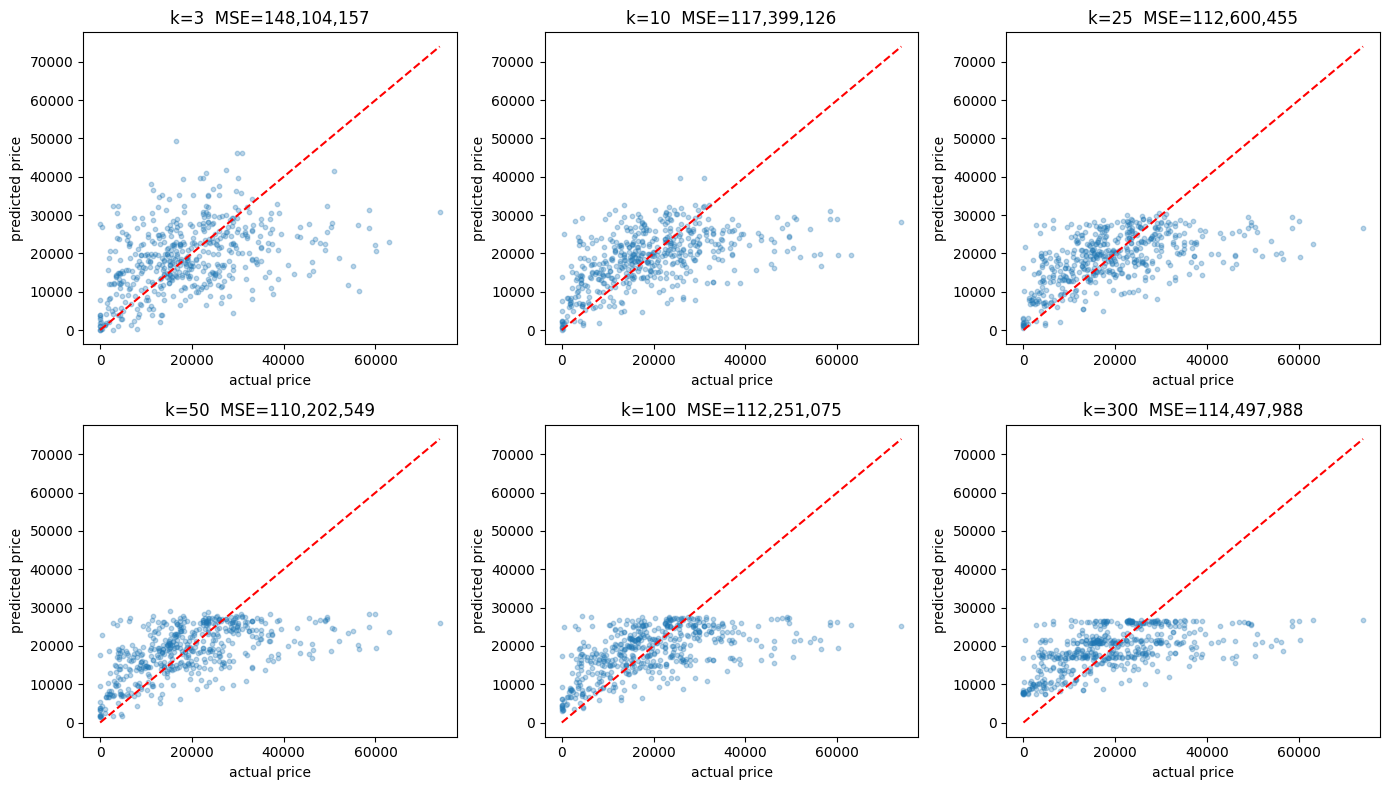

In [66]:
k_vals_reg = [3, 10, 25, 50, 100, 300]
mse_vals = []

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, k in enumerate(k_vals_reg):
    knn_reg = KNeighborsRegressor(n_neighbors=k)
    knn_reg.fit(X_cars_train, y_cars_train)
    y_hat = knn_reg.predict(X_cars_test)
    mse = mean_squared_error(y_cars_test, y_hat)
    mse_vals.append(mse)
    print(f"k={k:>4}  MSE={mse:,.0f}")

    axes[i].scatter(y_cars_test, y_hat, alpha=0.3, s=10)
    axes[i].plot([y_cars_test.min(), y_cars_test.max()],
                 [y_cars_test.min(), y_cars_test.max()], 'r--')
    axes[i].set_xlabel('actual price')
    axes[i].set_ylabel('predicted price')
    axes[i].set_title(f'k={k}  MSE={mse:,.0f}')

plt.tight_layout()
plt.show()

As we increase K, it just starts to only predict between 0 and about $28,000

5. Determine the optimal $k$ for these data.

In [67]:
best_k_reg = k_vals_reg[np.argmin(mse_vals)]
print(f"optimal k: {best_k_reg}, MSE: {min(mse_vals):,.0f}")

optimal k: 50, MSE: 110,202,549


6. Describe what happened in the plots of predicted versus actual prices as $k$ varied, taking your answer into part 6 into account. (Hint: Use the words "underfitting" and "overfitting".)

At small k (e.g. k=3) the model overfits — it chases noise in the training data and predictions are all over the place. As k grows the predictions become smoother but eventually underfit badly, averaging over too many neighbors and pulling predictions toward the mean. The optimal k is in between and minimizes test MSE.

**Q6.** This is a case study using $k$ nearest neighbor regression for imputation, using the `airbnb_hw.csv` data.

There are 30,478 observations, but only 22,155 ratings. We're going to build a kNN regressor to impute missing values. This is a common task, and illustrates one way you can use kNN in the future even when you have more advanced models available.

1. Load the `airbnb_hw.csv` data with Pandas. We're only going to use `Review Scores Rating`, `Price`, and `Beds`, so use `.loc` to column filter the dataframe to those variables.

In [74]:
airbnb = pd.read_csv("data/airbnb_hw.csv", encoding='latin1')
airbnb.columns = airbnb.columns.str.lower().str.strip().str.replace(" ", '_')
airbnb = airbnb.loc[:, ['review_scores_rating', 'price', 'beds']]

airbnb['price'] = airbnb['price'].str.replace(',', '').str.replace('$', '').astype(float)

print(airbnb.isna().sum())
airbnb.head()

review_scores_rating    8323
price                      0
beds                      85
dtype: int64


,review_scores_rating,price,beds
0,NaN,145.0,1.0
1,NaN,37.0,1.0
2,NaN,28.0,1.0
3,NaN,199.0,3.0
4,96.0,549.0,3.0


2. Set use `.isnull()` and `.loc` to select the subset of the dataframe with missing review values. Set those aside in a different dataframe. We'll make predictions about them later.

In [75]:
missing_ratings = airbnb.loc[airbnb['review_scores_rating'].isnull()].copy()
print(f"missing: {len(missing_ratings)}")
missing_ratings.head()

missing: 8323


,review_scores_rating,price,beds
0,NaN,145.0,1.0
1,NaN,37.0,1.0
2,NaN,28.0,1.0
3,NaN,199.0,3.0
13,NaN,68.0,1.0


3. Use `df = df.dropna(axis = 0, how = 'any')` to eliminate any observations with missing values/NA's from the dataframe.

In [76]:
airbnb = airbnb.dropna(axis=0, how='any')
print(f"complete: {len(airbnb)}")

complete: 22111


4. For the complete cases, create a $k$-NN model that uses the variables `Price` and `Beds` to predict `Review Scores Rating`. How do you choose $k$? (Hint: Train/test split, iterate over reasonable values of $k$ and find a value that minimizes SSE on the test split using predictions from the training set.)

In [71]:
X_ab = airbnb[['price', 'beds']]
y_ab = airbnb['review_scores_rating']

X_ab_train, X_ab_test, y_ab_train, y_ab_test = train_test_split(
    X_ab, y_ab, test_size=0.2, random_state=42
)

k_vals_ab = [3, 5, 10, 20, 50, 100, 200]
mse_ab = []
for k in k_vals_ab:
    knn_ab = KNeighborsRegressor(n_neighbors=k)
    knn_ab.fit(X_ab_train, y_ab_train)
    mse_ab.append(mean_squared_error(y_ab_test, knn_ab.predict(X_ab_test)))
    print(f"k={k:>4}  MSE={mse_ab[-1]:.3f}")

best_k_ab = k_vals_ab[np.argmin(mse_ab)]
print(f"\nbest k: {best_k_ab}")

k=   3  MSE=106.355
k=   5  MSE=88.405
k=  10  MSE=78.842
k=  20  MSE=74.455
k=  50  MSE=72.368
k= 100  MSE=71.662
k= 200  MSE=71.775

best k: 100


I chose k by iterating over a range of values and picking the one that minimizes MSE on the test set like with the earlier exercise.

5. Predict the missing ratings. 

In [77]:
knn_ab_best = KNeighborsRegressor(n_neighbors=best_k_ab)
knn_ab_best.fit(X_ab_train, y_ab_train)

X_missing = missing_ratings[['price', 'beds']].dropna()
imputed_ratings = knn_ab_best.predict(X_missing)
print(f"imputed {len(imputed_ratings)} ratings")
print(pd.Series(imputed_ratings).describe())

imputed 8282 ratings
count    8282.000000
mean       92.105210
std         1.726129
min        85.900000
25%        90.892500
50%        92.470000
75%        93.270000
max        95.830000
dtype: float64


6. Do a kernel density plot of the training ratings and the predicted missing ratings. Do they look similar or not? Describe what you see.

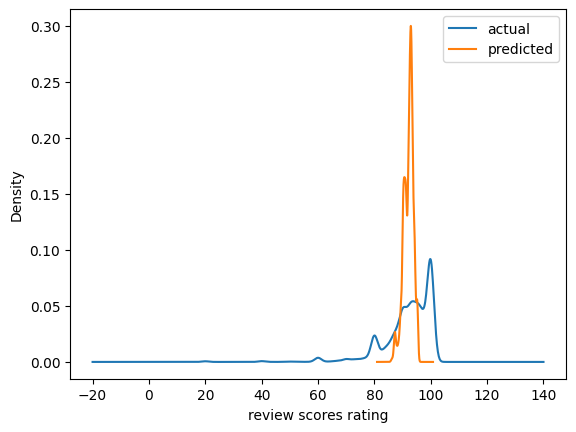

In [79]:
airbnb['review_scores_rating'].plot.kde(label='actual')
pd.Series(imputed_ratings).plot.kde(label='predicted')
plt.xlabel('review scores rating')
plt.legend()
plt.show()

It looks like our algorithmn is underfitting and predicting close to the mean every time.